In [114]:
using JuMP, Ipopt
using Plots

basicTerrain(x, y) = exp(-1(x^2 + y^2))

function potential(vec)
    return basicTerrain(vec[1], vec[2])
end

k = 3              
instances = zeros(Int,4)  
wps = zeros(2,k)    

instances[1] = 1
instances[2] = 20
instances[3] = 50
instances[4] = 100

# define waypoints
wps = [-2 -2;
        0  0;

       -2 -2]

function least_dangerous(λ) # λ é o parâmetro de regularização

    m = Model(Ipopt.Optimizer)
    register(m, :basicTerrain, 2, basicTerrain, autodiff=true)
    set_optimizer_attributes(m, "print_level" => 0 )
    @variable(m, position[1:instances[k], 1:2]) # Position
    @variable(m, velocity[1:instances[k], 1:2]) # Velocity
    @variable(m, thrust[1:instances[k], 1:2])   # Thrust

    # Dynamics (no initial velocity)
    @constraint(m, velocity[1,:] .== [0 0])

    #@constraint(m, [-0.1 -0.1] .<= velocity .<= [0.1 0.1])
    #@constraint(m, [-0.1 -0.1] .<= thrust .<= [0.1 0.1])
    


    for t in 1:instances[k]-1
        # Position is updated in thrust
        @constraint(m, position[t+1,:] .== position[t,:] + velocity[t,:])
        @NLconstraint(m, velocity[t+1,:1] + basicTerrain(position[t,:]...) == velocity[t,:1] + thrust[t,:1] + basicTerrain(position[t+1,:]...))
        @NLconstraint(m, velocity[t+1,:2] + basicTerrain(position[t,:]...) == velocity[t,:2] + thrust[t,:2] + basicTerrain(position[t+1,:]...))
    end

    # Reach all waypoints
    for i in [1 k]
        @constraint(m, position[instances[i],:] .== wps[i,:])
    end

    @objective(m, Min, sum(thrust.^2) + λ*sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ) )
    optimize!(m)
    
    J1 = value.(sum(thrust.^2))
    J2 = value.(sum( (position[instances[2:k],:]-wps[2:k,:]).^2  ))
    velocity = value.(velocity)
    thrust = value.(thrust)
    path = value.(position)
    
    return (velocity,thrust,path)
end

least_dangerous (generic function with 1 method)

In [115]:
λ = 1
(velocity,thrust,path) = least_dangerous(λ)


([4.988384673842859e-19 3.1960583183599905e-19; 0.011938050138337876 0.022131046089282937; … ; -0.36362345785336914 -0.10291489511857146; -0.36516763715578016 -0.10445906145509867], [0.011938050138337876 0.022131046089282933; 0.010480203304506278 0.01888659619193081; … ; 2.6127258540167365e-8 3.9093142322128467e-8; 0.0 0.0], [-2.0 -2.0; -2.0 -2.0; … ; -1.6363765421466308 -1.8970851048814286; -2.0 -2.0])

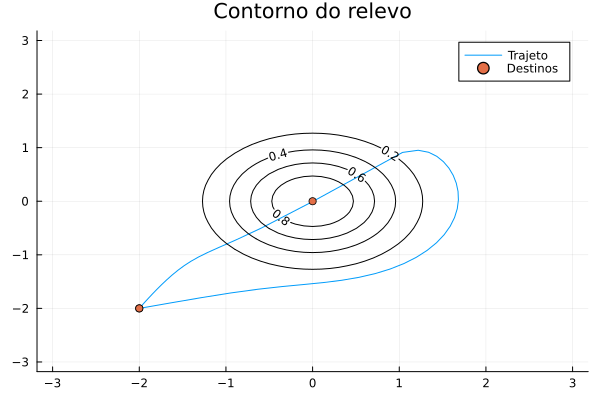

In [116]:
plot(path[:,1], path[:,2], label="Trajeto")
scatter!(wps[:,1], wps[:,2], label="Destinos")
contour!(-3:0.1:3, -3:0.1:3, basicTerrain, color=:black, clabels=true, levels=4, cbar=false, title="Contorno do relevo")

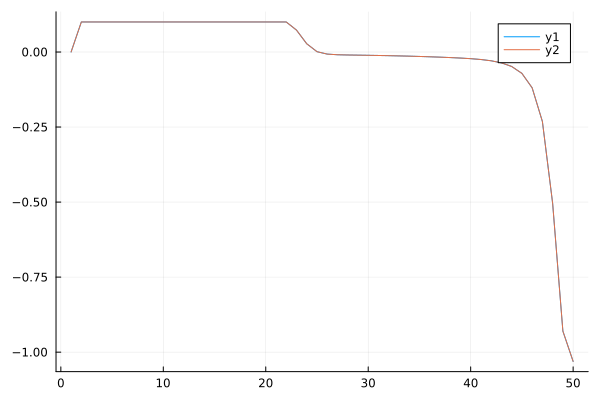

In [109]:
plot(velocity)
#plot!(sqrt.(thrust[1,:].^2 + thrust[2,:].^2))
#plot!(basicTerrain.(path...))
